In [4]:
#importing necessary libraries for preprocessing
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

## **PREPROCESSING**

In [5]:
#transformations to be applied on training set as well as rescaling the images
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [6]:
#rescaling pixel values for the test set, also called normalizing to give values between 0 and 1
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

In [7]:
#Directory path for both training and test set
train_dir = '/content/drive/MyDrive/Chest CT-Scan images Dataset/train'
test_dir = '/content/drive/MyDrive/Chest CT-Scan images Dataset/test'

In [9]:
#Batch size for image training
batch_size = 32

#resizing to be used on all images
img_width, img_height = 224, 224

In [10]:
#training sets preprocessing
train_generator = train_datagen.flow_from_directory(
  train_dir,
  batch_size = batch_size,
  target_size = (img_width, img_height),
  class_mode = 'categorical'
)

#test set preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size = batch_size,
    target_size = (img_width, img_height),
    class_mode = 'categorical'
)

Found 675 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


## **MODEL TRAINING**

In [23]:
#Importing necessary model training libraries
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [12]:
#Loading resnet50 pretrained model
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [13]:
#not retraining base model layers
for layer in base_model.layers:
  layer.trainable = False

In [14]:
#setting modelcheckpoint to save weights with the highest validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath = 'best_model.h5',
    save_best_only = True,
    monitor = 'val_accuracy',
    verbose = 1,
    mode = 'max'
)

In [15]:
#setting callback to stop model once val_accuracy is at it's maximum
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.002,
    patience = 15,
    restore_best_weights = True
)

In [16]:
#callback to reduce learning rates
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience=10,
    min_lr = 0.0001,
    factor = 0.1,
    min_delta = 0.0001
)

In [17]:
#setting my callback to contain both Model Checkpoint and learning rate reducer
callback = [reduce_lr]

In [18]:
# compiling my pretrained ResNet50 model with other dense layers
model = Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [19]:
#specifying optimizers, loss and metrics to check accuracy
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [22]:
#model training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callback,
    verbose=1
)

Epoch 1/50
22/22 [==============================] - 16s 731ms/step - loss: 0.4252 - accuracy: 0.8296 - val_loss: 0.5252 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 16s 717ms/step - loss: 0.3556 - accuracy: 0.8578 - val_loss: 0.5316 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 16s 720ms/step - loss: 0.4568 - accuracy: 0.8341 - val_loss: 0.5154 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 19s 862ms/step - loss: 0.5334 - accuracy: 0.8015 - val_loss: 0.5482 - val_accuracy: 0.7746 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - 16s 720ms/step - loss: 0.3581 - accuracy: 0.8726 - val_loss: 0.5549 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - 16s 723ms/step - loss: 0.4890 - accuracy: 0.8074 - val_loss: 0.5158 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 7/50
22/22 [==============================] - 16s 733ms/st

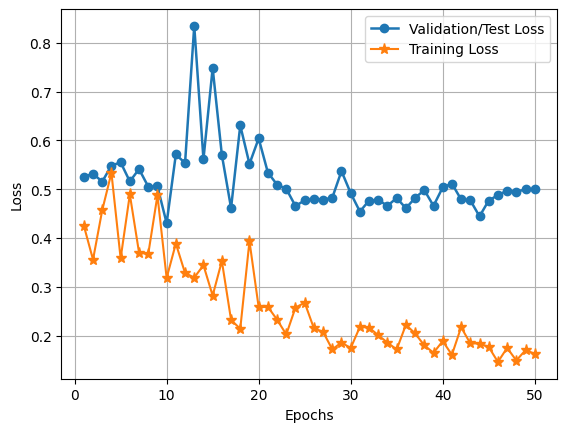

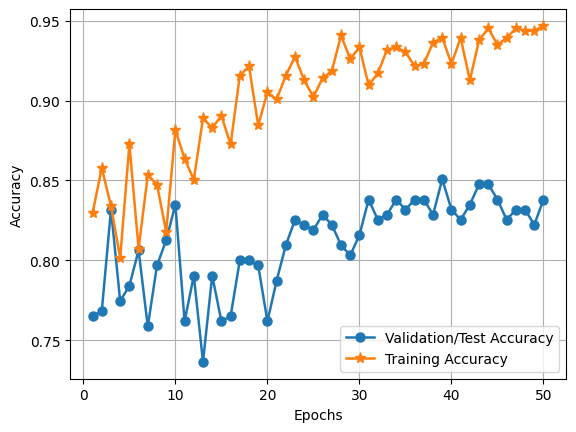

In [24]:
#Plotting the loss charts

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

#Plotting the accuracy charts

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## **Saving My Model**

In [25]:
#saving my trained model
model.save('chest_cancer_detector.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
#downloading my saved model
from google.colab import files

# Download the saved model
files.download('chest_cancer_detector.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
#downloading requirement.txt file
!pip freeze > requirements.txt
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>